<a href="https://colab.research.google.com/github/radhakrishnan-omotec/avm-repository/blob/master/YoloWorld_object_detection_with_LEFT_RIGHT_CENTER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Object Detection with YOLO-World for Location of LEFT/RIGHT/CENTER
<br>
<hr>

- YOLO-World was designed to solve a limitation of existing zero-shot object detection models: speed.
- Whereas other state-of-the-art models use Transformers, a powerful but typically slower architecture, YOLO-World uses the faster CNN-based YOLO architecture.


<hr>

In [1]:
!nvidia-smi

Thu Sep 12 08:50:46 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P8              12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

- The command !nvidia-smi is typically used in environments where NVIDIA GPU drivers are installed.

- It is a command-line utility provided by NVIDIA to monitor and manage NVIDIA GPU devices installed on the system.

- nvidia-smi: It stands for "NVIDIA System Management Interface". When executed, it displays detailed information about the currently installed NVIDIA GPUs, including their utilization, memory usage, temperature, power usage, and more.

In [2]:
import os
HOME = os.getcwd()
print(HOME)

/content


- import os: This line imports the Python built-in module os, which provides a way to interact with the operating system, such as navigating the file system, working with files and directories, and accessing environment variables.

- HOME = os.getcwd(): This line calls the os.getcwd() function. getcwd() stands for "get current working directory". It returns a string representing the current working directory of the Python script that is being executed. This directory is typically the location from which the script was launched.

- print(HOME): This line prints out the value of the variable HOME, which now holds the path of the current working directory.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Installing required packages

Here, we utilize two Python packages: `inference`, for executing zero-shot object detection using YOLO-World, and `supervision`, for post-processing and visualizing the detected objects.

In [5]:
!pip install -q inference-gpu[yolo-world]==0.9.12rc1

- !pip: This tells the Python interpreter to run the following command using pip, which is a package manager for Python.

- install: This is the pip command to install packages.

- -q: This flag stands for quiet mode, which suppresses output during installation.

- inference-gpu[yolo-world]==0.9.12rc1: This is the package name along with the specified version you want to install. It includes the inference-gpu package with the YOLO World extension at version 0.9.12rc1.

In [6]:
!pip install -q supervision==0.19.0rc3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.8/90.8 kB 7.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inference-sdk 0.17.0 requires supervision<1.0.0,>=0.20.0, but you have supervision 0.19.0rc3 which is incompatible.


- supervision is a library developed by roboflow which is used for several computer vision tasks

## Imports

In [7]:
import cv2
import supervision as sv

from tqdm import tqdm
from inference.models.yolo_world.yolo_world import YOLOWorld

[09/12/24 08:56:44] WARNING  Your inference package version 0.9.12rc1 is out of date! Please upgrade ]8;id=815350;file:///usr/local/lib/python3.10/dist-packages/inference/core/__init__.py\__init__.py]8;;\:]8;id=956728;file:///usr/local/lib/python3.10/dist-packages/inference/core/__init__.py#35\35]8;;\
                             to version 0.18.1 of inference for the latest features and bug fixes by               
                             running `pip install --upgrade inference`.                                            

- cv2: This is the OpenCV library, which is commonly used for image processing tasks such as reading, writing, and manipulating images.

- supervision as sv: This imports the supervision package and gives it the alias sv. supervision is a set of easy-to-use utils that will come in handy in any Computer Vision project.

- from tqdm import tqdm: This imports the tqdm module, which provides a progress bar for iterables like loops and iterators. It's often used to visualize the progress of tasks in a loop.

- from inference.models.yolo_world.yolo_world import YOLOWorld: This imports the YOLOWorld class from the inference.models.yolo_world.yolo_world module. We're working with a YOLO (You Only Look Once) model for object detection, specifically from the inference package.

In [8]:
!wget -P {HOME} -q https://media.roboflow.com/notebooks/examples/dog.jpeg
!wget -P {HOME} -q https://media.roboflow.com/supervision/cookbooks/yellow-filling.mp4

In [9]:
SOURCE_IMAGE_PATH = f"{HOME}/dog.jpeg"
SOURCE_VIDEO_PATH = f"{HOME}/yellow-filling.mp4"

- SOURCE_IMAGE_PATH: This variable holds the file path to an image named "peoples-755726_1280.jpg". The path is constructed by combining the HOME variable, which represents the current working directory, with the image filename.

- SOURCE_VIDEO_PATH: This variable holds the file path to a video named "yellow-filling.mp4". Similar to the image path, it's constructed by combining the HOME variable with the video filename.

- The Inference package provides the YOLO-World model in three versions: `S`, `M`, and `L`. You can load them by defining model_id as `yolo_world/s`, `yolo_world/m`, and `yolo_world/l`, respectively. The `ROBOFLOW_API_KEY` is not required to utilize this model.







100%|███████████████████████████████████████| 338M/338M [00:09<00:00, 36.7MiB/s]


Object detected at the center of the image.
Object detected at the center of the image.
Object detected at the right of the image.


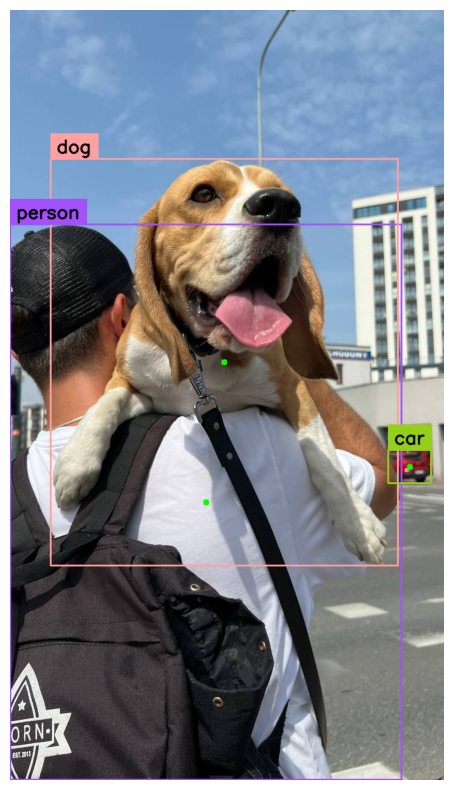

In [11]:
import cv2
import supervision as sv

# Function to determine if the center is on the left, center, or right side of the image
def determine_position(center_x, image_width):
    # Divide the image width into three parts: left, center, and right
    third_width = image_width // 3
    if center_x < third_width:
        return "left"
    elif center_x < 2 * third_width:
        return "center"
    else:
        return "right"

# Load the YOLOWorld model with specific classes
model = YOLOWorld(model_id="yolo_world/l")
classes = ["person", "backpack", "dog", "eye", "nose", "ear", "tongue", "car", "traffic lights"]
model.set_classes(classes)

# Load the image
image = cv2.imread(SOURCE_IMAGE_PATH)
image_height, image_width, _ = image.shape  # Get the dimensions of the image

# Perform inference
results = model.infer(image)
detections = sv.Detections.from_inference(results)

# Initialize annotators
BOUNDING_BOX_ANNOTATOR = sv.BoundingBoxAnnotator(thickness=2)
LABEL_ANNOTATOR = sv.LabelAnnotator(text_thickness=2, text_scale=1, text_color=sv.Color.BLACK)

# Annotate image with bounding boxes and labels
annotated_image = image.copy()
annotated_image = BOUNDING_BOX_ANNOTATOR.annotate(annotated_image, detections)
annotated_image = LABEL_ANNOTATOR.annotate(annotated_image, detections)

# Iterate through detections and draw the center of bounding boxes
for detection in detections:
    # Ensure detection is a tuple or list, with the first element being the bounding box
    bbox = detection[0] if isinstance(detection, (tuple, list)) else detection.bbox

    # Extract the bounding box coordinates (x_min, y_min, x_max, y_max)
    x_min, y_min, x_max, y_max = bbox

    # Calculate the center coordinates of the bounding box
    center_x = int((x_min + x_max) / 2)
    center_y = int((y_min + y_max) / 2)

    # Draw a small circle at the center of the bounding box
    cv2.circle(annotated_image, (center_x, center_y), radius=5, color=(0, 255, 0), thickness=-1)

    # Check if the center is on the left, center, or right side of the image
    position = determine_position(center_x, image_width)
    print(f"Object detected at the {position} of the image.")

# Display the annotated image
sv.plot_image(annotated_image, (10, 10))

Object detected at the CENTER of the image.
Object detected at the CENTER of the image.
Object detected at the RIGHT of the image.


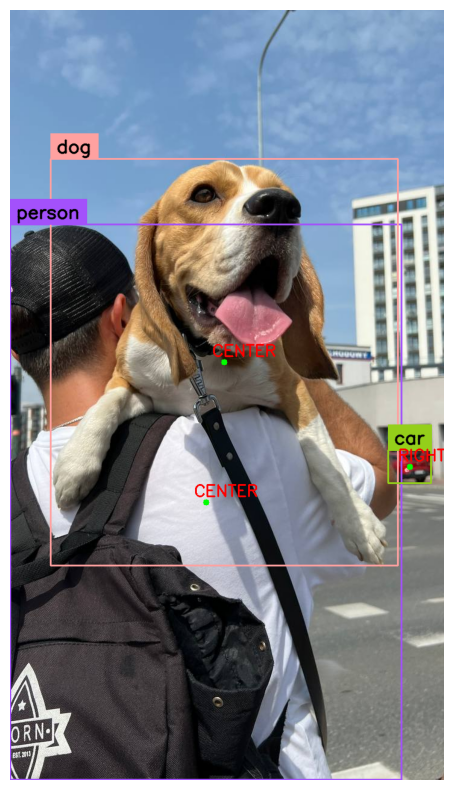

In [12]:
import cv2
import supervision as sv

# Function to determine if the center is on the left, center, or right side of the image
def determine_position(center_x, image_width):
    # Divide the image width into three parts: left, center, and right
    third_width = image_width // 3
    if center_x < third_width:
        return "LEFT"
    elif center_x < 2 * third_width:
        return "CENTER"
    else:
        return "RIGHT"

# Load the YOLOWorld model with specific classes
model = YOLOWorld(model_id="yolo_world/l")
classes = ["person", "backpack", "dog", "eye", "nose", "ear", "tongue", "car", "traffic lights"]
model.set_classes(classes)

# Load the image
image = cv2.imread(SOURCE_IMAGE_PATH)
image_height, image_width, _ = image.shape  # Get the dimensions of the image

# Perform inference
results = model.infer(image)
detections = sv.Detections.from_inference(results)

# Initialize annotators
BOUNDING_BOX_ANNOTATOR = sv.BoundingBoxAnnotator(thickness=2)
LABEL_ANNOTATOR = sv.LabelAnnotator(text_thickness=2, text_scale=1, text_color=sv.Color.BLACK)

# Annotate image with bounding boxes and labels
annotated_image = image.copy()
annotated_image = BOUNDING_BOX_ANNOTATOR.annotate(annotated_image, detections)
annotated_image = LABEL_ANNOTATOR.annotate(annotated_image, detections)

# Iterate through detections and draw the center of bounding boxes
for detection in detections:
    # Ensure detection is a tuple or list, with the first element being the bounding box
    bbox = detection[0] if isinstance(detection, (tuple, list)) else detection.bbox

    # Extract the bounding box coordinates (x_min, y_min, x_max, y_max)
    x_min, y_min, x_max, y_max = bbox

    # Calculate the center coordinates of the bounding box
    center_x = int((x_min + x_max) / 2)
    center_y = int((y_min + y_max) / 2)

    # Draw a small circle at the center of the bounding box
    cv2.circle(annotated_image, (center_x, center_y), radius=5, color=(0, 255, 0), thickness=-1)

    # Check if the center is on the left, center, or right side of the image
    position = determine_position(center_x, image_width)

    # Print position in the console
    print(f"Object detected at the {position} of the image.")

    # Annotate the image with the position text ("LEFT", "CENTER", or "RIGHT")
    cv2.putText(
        annotated_image,
        position,
        (center_x - 20, center_y - 10),  # Positioning the text slightly above the center
        cv2.FONT_HERSHEY_SIMPLEX,
        0.9,  # Font scale
        (0, 0, 255),  # Text color (red)
        2  # Text thickness
    )

# Display the annotated image
sv.plot_image(annotated_image, (10, 10))